In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
import scipy.stats as ss
from sklearn.impute import SimpleImputer
from sklearn.utils import resample
import numpy as np
from sklearn.model_selection import train_test_split

In [3]:
df = pd.read_csv('./data/Guns incident Data.csv')
df.head()

,S.No.,Year,Month,Date,Reason,Education,Sex,Age,Race,Hispanic,Place of incident,Police involvement
0,1,2017,1,06-01-2017,Suicide,Bachelors,Male,35.0,Asian/Pacific Islander,100,Home,0
1,2,2017,1,19-01-2017,Suicide,Some college,Female,22.0,White,100,Street,0
2,3,2017,1,01-01-2017,Suicide,Bachelors,Male,61.0,White,100,Other specified,0
3,4,2017,2,06-02-2017,Suicide,Bachelors,Male,65.0,White,100,Home,0
4,5,2017,2,09-02-2017,Suicide,High School,Male,32.0,White,100,Other specified,0


# Data cleaning

In [4]:
df_clean = df.drop(['S.No.', 'Date', 'Hispanic'], axis=1)
df_clean.insert(0, 'Reason', df_clean.pop('Reason'))
df_clean.head()

,Reason,Year,Month,Education,Sex,Age,Race,Place of incident,Police involvement
0,Suicide,2017,1,Bachelors,Male,35.0,Asian/Pacific Islander,Home,0
1,Suicide,2017,1,Some college,Female,22.0,White,Street,0
2,Suicide,2017,1,Bachelors,Male,61.0,White,Other specified,0
3,Suicide,2017,2,Bachelors,Male,65.0,White,Home,0
4,Suicide,2017,2,High School,Male,32.0,White,Other specified,0


# Exploratory Data Analysis

In [5]:
na_percentage = df_clean.isna().sum() / df.shape[0] * 100

na_percentage = na_percentage.round(2)
print("Percentage of NaN values for each variable:")
print(na_percentage)

Percentage of NaN values for each variable:
Reason                0.00
Year                  0.00
Month                 0.00
Education             1.41
Sex                   0.00
Age                   0.02
Race                  0.00
Place of incident     1.37
Police involvement    0.00
dtype: float64


C:\Users\Gan Wan Yi\AppData\Local\Temp\ipykernel_3504\1487412868.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


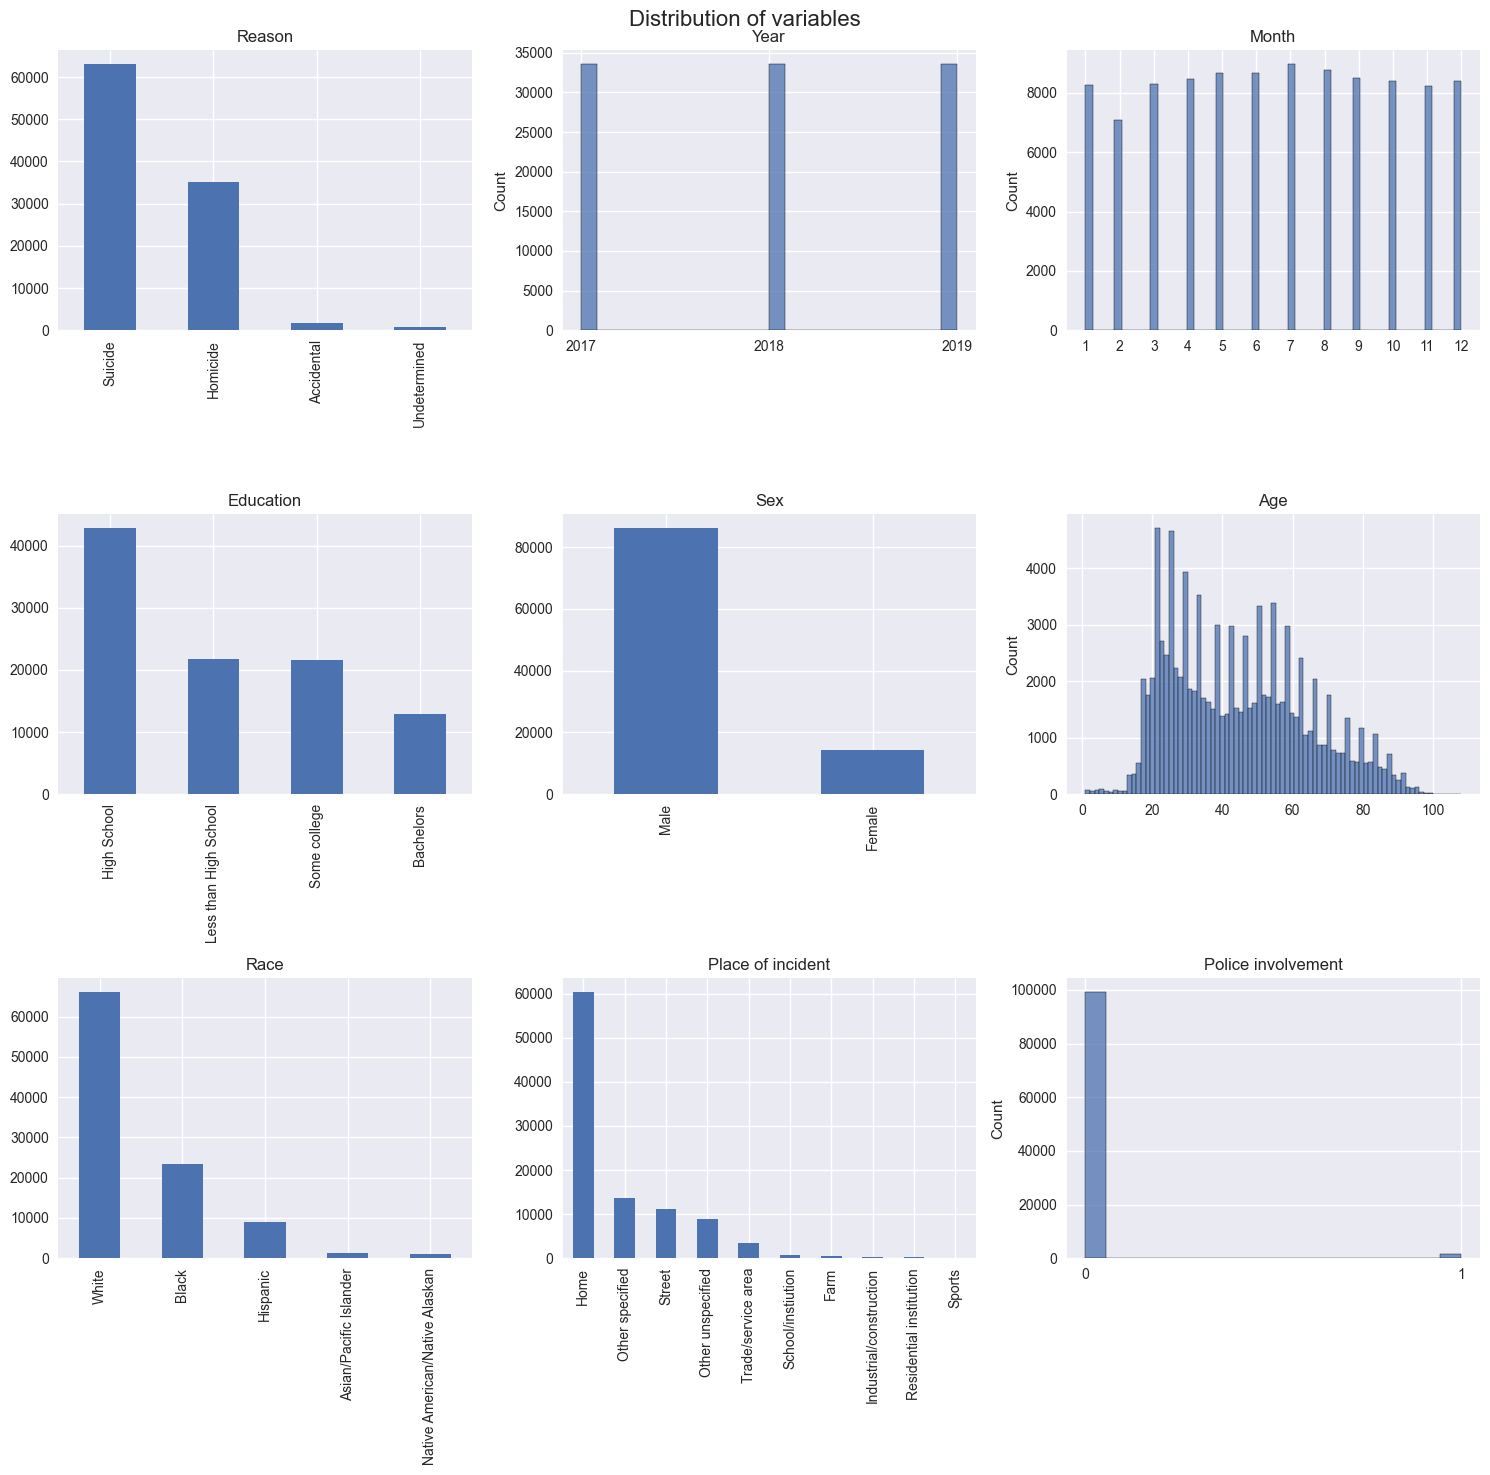

In [6]:
discrete_numerical_var = ['Year','Month','Police involvement']
continuous_numerical_var = ['Age']
categorical_var = ['Education','Sex','Race','Place of incident','Reason']

plt.style.use('seaborn')
fig,axs = plt.subplots(3,3, figsize=(15,15))
fig.suptitle('Distribution of variables', fontsize = 16)
idx = 0

for i in range(3):
  for j in range(3):
    var = df_clean.columns[idx]
    if var in discrete_numerical_var:
      sns.histplot(data = df, x = var, ax=axs[i,j])
      axs[i, j].set_xticks(range(min(df[var]),max(df[var])+1,1))
    elif var in continuous_numerical_var:
      sns.histplot(data = df, x = var, ax=axs[i,j])
    else:
      df[var].value_counts().plot(kind='bar', ax=axs[i,j])
    axs[i,j].set_xlabel('')
    axs[i,j].set_title(var)
    idx += 1

plt.tight_layout()

# Removal of Missing Data #

In [7]:
rows_with_missing = df_clean[df_clean.isnull().any(axis=1)]
print(rows_with_missing.shape)
columns_with_missing = df_clean.columns[df_clean.isnull().any()]
print(columns_with_missing)

(2783, 9)
Index(['Education', 'Age', 'Place of incident'], dtype='object')


### remove all missing data ###

In [8]:
df_clean_remove = df_clean.dropna()

### impute all missing data ###

In [9]:
# Impute ALL Missing Values
df_clean_impute = df_clean.copy()

# Age
age_imputer = SimpleImputer(strategy='median')
df_clean_impute['Age'] = age_imputer.fit_transform(df_clean[['Age']])

# Education
education_counts = df_clean_impute['Education'].value_counts(normalize=True)
education_categories = education_counts.index.tolist()
education_probs = education_counts.values

np.random.seed(1)

df_clean_impute['Education'] = df_clean_impute['Education'].apply(
    lambda x: np.random.choice(education_categories, p = education_probs) if pd.isnull(x) else x
)

# Place of incident
place_counts = df_clean_impute['Place of incident'].value_counts(normalize=True)
place_categories = place_counts.index.tolist()
place_probs = place_counts.values

np.random.seed(1)

df_clean_impute['Place of incident'] = df_clean_impute['Place of incident'].apply(
    lambda x: np.random.choice(place_categories, p=place_probs) if pd.isnull(x) else x
)

# Encoding #

### encoding of data where missing values are removed ###

In [10]:
cleanup_nums = {"Education":     {"Less than High School": 0, "High School": 1,"Some college":2,"Bachelors":3}}       
df_clean_remove = df_clean_remove.replace(cleanup_nums)

#one hot encoding for gender
gender_ohe=pd.get_dummies(df_clean_remove.Sex) #gender one hot encoding
dftemp=df_clean_remove
dftemp=dftemp.drop(columns=["Sex"])
dftemp=pd.concat([gender_ohe,dftemp],axis=1)

#one hot encoding for race
race_ohe=pd.get_dummies(df_clean_remove.Race) #race one hot encoding
dftemp=dftemp.drop(columns=["Race"])
dftemp=pd.concat([race_ohe,dftemp],axis=1)

#one hot encoding for place of incident
place_ohe=pd.get_dummies(df_clean_remove["Place of incident"]) #place one hot encoding
dftemp=dftemp.drop(columns=["Place of incident"])
dftemp= pd.concat([place_ohe,dftemp],axis=1)

df_clean_remove = dftemp


### encoding of data where missing values are imputed ###

In [11]:
df_clean_impute = df_clean_impute.replace(cleanup_nums)

#one hot encoding for gender
gender_ohe=pd.get_dummies(df_clean_impute.Sex) #gender one hot encoding
dftemp=df_clean_impute
dftemp=dftemp.drop(columns=["Sex"])
dftemp=pd.concat([gender_ohe,dftemp],axis=1)

#one hot encoding for race
race_ohe=pd.get_dummies(df_clean_impute.Race) #race one hot encoding
dftemp=dftemp.drop(columns=["Race"])
dftemp=pd.concat([race_ohe,dftemp],axis=1)

#one hot encoding for place of incident
place_ohe=pd.get_dummies(df_clean_impute["Place of incident"]) #place one hot encoding
dftemp=dftemp.drop(columns=["Place of incident"])
dftemp= pd.concat([place_ohe,dftemp],axis=1)

df_clean_impute = dftemp

# Splitting Into Test and Train Datasets #

In [12]:
''' 80-20 ratio used, 80% data used for training, 20% used for testing '''
df_clean_impute_train, df_clean_impute_test = train_test_split(df_clean_impute, test_size=0.2, random_state=42)
df_clean_remove_train, df_clean_remove_test = train_test_split(df_clean_remove, test_size=0.2, random_state=42)

# Resampling Under-represented Classes #

### for imputed data ###

In [13]:
#resampling for training data 

#df_clean_impute_train['Reason'].value_counts(), majority class for imputed training data is suicide 
mclass_len = df_clean_impute_train[df_clean_impute_train['Reason']=='Suicide'].shape[0]
'''underrepresented classes are homicide, accidental, undetermined
with majority class suicide having 50580 rows '''

majority_class_suicide = df_clean_impute_train[df_clean_impute_train['Reason']=='Suicide']
minority_class_homicide = df_clean_impute_train[df_clean_impute_train['Reason']=='Homicide']
minority_class_accidental = df_clean_impute_train[df_clean_impute_train['Reason']=='Accidental']
minority_class_undetermined= df_clean_impute_train[df_clean_impute_train['Reason']=='Undetermined']

df_ci_oversamp_hom = resample(minority_class_homicide, replace=True, n_samples = mclass_len, random_state=42)
df_ci_oversamp_acc = resample(minority_class_accidental, replace=True, n_samples = mclass_len, random_state=42)
df_ci_oversamp_und = resample(minority_class_undetermined, replace=True, n_samples = mclass_len, random_state=42)

df_clean_impute_train= pd.concat([majority_class_suicide,df_ci_oversamp_hom,df_ci_oversamp_acc, df_ci_oversamp_und])


#resampling for testing data 

#df_clean_impute_test['Reason'].value_counts(), majority class for imputed training data is suicide 
mclass_len = df_clean_impute_test[df_clean_impute_test['Reason']=='Suicide'].shape[0]
'''underrepresented classes are homicide, accidental, undetermined
with majority class suicide having 50580 rows '''

majority_class_suicide = df_clean_impute_test[df_clean_impute_test['Reason']=='Suicide']
minority_class_homicide = df_clean_impute_test[df_clean_impute_test['Reason']=='Homicide']
minority_class_accidental = df_clean_impute_test[df_clean_impute_test['Reason']=='Accidental']
minority_class_undetermined= df_clean_impute_test[df_clean_impute_test['Reason']=='Undetermined']

df_ci_oversamp_hom = resample(minority_class_homicide, replace=True, n_samples = mclass_len, random_state=42)
df_ci_oversamp_acc = resample(minority_class_accidental, replace=True, n_samples = mclass_len, random_state=42)
df_ci_oversamp_und = resample(minority_class_undetermined, replace=True, n_samples = mclass_len, random_state=42)

df_clean_impute_test= pd.concat([majority_class_suicide,df_ci_oversamp_hom,df_ci_oversamp_acc, df_ci_oversamp_und])

### for data where missing values are removed ###

In [14]:
#resampling for training data 

#df_clean_remove_train['Reason'].value_counts(), majority class for imputed training data is suicide 
mclass_len = df_clean_remove_train[df_clean_remove_train['Reason']=='Suicide'].shape[0]
'''underrepresented classes are homicide, accidental, undetermined with majority class suicide having 49818 rows '''

majority_class_suicide = df_clean_remove_train[df_clean_remove_train['Reason']=='Suicide']
minority_class_homicide = df_clean_remove_train[df_clean_remove_train['Reason']=='Homicide']
minority_class_accidental = df_clean_remove_train[df_clean_remove_train['Reason']=='Accidental']
minority_class_undetermined= df_clean_remove_train[df_clean_remove_train['Reason']=='Undetermined']

df_cr_oversamp_hom = resample(minority_class_homicide, replace=True, n_samples = mclass_len, random_state=4) #df_cleanremove_...
df_cr_oversamp_acc = resample(minority_class_accidental, replace=True, n_samples = mclass_len, random_state=4)
df_cr_oversamp_und = resample(minority_class_undetermined, replace=True, n_samples = mclass_len, random_state=4)

df_clean_remove_train= pd.concat([majority_class_suicide,df_cr_oversamp_hom,df_cr_oversamp_acc, df_cr_oversamp_und])

#resampling for testing data 

#df_clean_remove_test['Reason'].value_counts(), majority class for imputed training data is suicide 
mclass_len = df_clean_remove_test[df_clean_remove_test['Reason']=='Suicide'].shape[0]
'''underrepresented classes are homicide, accidental, undetermined with majority class suicide having 12473 rows '''

majority_class_suicide = df_clean_remove_test[df_clean_remove_test['Reason']=='Suicide']
minority_class_homicide = df_clean_remove_test[df_clean_remove_test['Reason']=='Homicide']
minority_class_accidental = df_clean_remove_test[df_clean_remove_test['Reason']=='Accidental']
minority_class_undetermined= df_clean_remove_test[df_clean_remove_test['Reason']=='Undetermined']

df_cr_oversamp_hom = resample(minority_class_homicide, replace=True, n_samples = mclass_len, random_state=42)
df_cr_oversamp_acc = resample(minority_class_accidental, replace=True, n_samples = mclass_len, random_state=42)
df_cr_oversamp_und = resample(minority_class_undetermined, replace=True, n_samples = mclass_len, random_state=42)

df_clean_remove_test= pd.concat([majority_class_suicide,df_cr_oversamp_hom,df_cr_oversamp_acc, df_cr_oversamp_und])

In [15]:
df_clean_remove_test

,Farm,Home,Industrial/construction,Other specified,Other unspecified,Residential institution,School/instiution,Sports,Street,Trade/service area,...,Native American/Native Alaskan,White,Female,Male,Reason,Year,Month,Education,Age,Police involvement
58187,0,1,0,0,0,0,0,0,0,0,...,0,1,0,1,Suicide,2018,1,1,45.0,0
57619,0,1,0,0,0,0,0,0,0,0,...,0,1,0,1,Suicide,2018,6,2,86.0,0
8683,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,Suicide,2017,11,1,50.0,0
6930,0,1,0,0,0,0,0,0,0,0,...,0,1,0,1,Suicide,2017,4,2,57.0,0
52778,0,1,0,0,0,0,0,0,0,0,...,0,1,1,0,Suicide,2018,8,1,64.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58190,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,Undetermined,2018,3,0,30.0,0
56499,0,1,0,0,0,0,0,0,0,0,...,0,1,0,1,Undetermined,2018,10,3,76.0,0
86921,0,1,0,0,0,0,0,0,0,0,...,0,1,0,1,Undetermined,2019,1,3,25.0,0
22464,0,1,0,0,0,0,0,0,0,0,...,0,1,0,1,Undetermined,2017,5,3,61.0,0


### XGBoost ###

In [16]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [17]:
X_remove_train = df_clean_remove_train.drop(columns=['Reason'])
y_remove_train = df_clean_remove_train['Reason']

X_remove_test = df_clean_remove_test.drop(columns=['Reason'])
y_remove_test = df_clean_remove_test['Reason']

X_impute_train = df_clean_impute_train.drop(columns=['Reason'])
y_impute_train = df_clean_impute_train['Reason']

X_impute_test = df_clean_impute_test.drop(columns=['Reason'])
y_impute_test = df_clean_impute_test['Reason']

In [41]:
#replacing our labels with [0 1 2 3] for XGBoost because it literally refuses to take the categorical labels
labels_numeric = {"Accidental": 0, "Homicide": 1,"Suicide":2,"Undetermined":3}

y_remove_train_num = y_remove_train.replace(labels_numeric)
y_remove_test_num = y_remove_test.replace(labels_numeric)

y_impute_train_num = y_impute_train.replace(labels_numeric)
y_impute_test_num = y_impute_test.replace(labels_numeric)


In [33]:
y_remove_test_num.head()

58187    2
57619    2
8683     2
6930     2
52778    2
Name: Reason, dtype: int64

In [40]:
xgb_train_remove = xgb.XGBClassifier()
xgb_train_remove.fit(X_remove_train, y_remove_train_num)

xgb_y_remove_pred = xgb_train_remove.predict(X_remove_test)
xgb_remove_accuracy = accuracy_score(y_remove_test_num, xgb_y_remove_pred)
xgb_remove_report = classification_report(y_remove_test_num, xgb_y_remove_pred)

print(xgb_remove_accuracy)
print(xgb_remove_report)

0.4431973061813517
              precision    recall  f1-score   support

           0       0.40      0.25      0.31     12473
           1       0.57      0.70      0.63     12473
           2       0.40      0.65      0.50     12473
           3       0.33      0.17      0.22     12473

    accuracy                           0.44     49892
   macro avg       0.42      0.44      0.41     49892
weighted avg       0.42      0.44      0.41     49892



In [42]:
xgb_train_impute = xgb.XGBClassifier()
xgb_train_impute.fit(X_impute_train, y_impute_train_num)

xgb_y_impute_pred = xgb_train_impute.predict(X_impute_test)
xgb_impute_accuracy = accuracy_score(y_impute_test_num, xgb_y_impute_pred)
xgb_impute_report = classification_report(y_impute_test_num, xgb_y_impute_pred)

print(xgb_impute_accuracy)
print(xgb_impute_report)

0.43729654624851133
              precision    recall  f1-score   support

           0       0.38      0.23      0.28     12595
           1       0.55      0.71      0.62     12595
           2       0.42      0.66      0.51     12595
           3       0.29      0.15      0.20     12595

    accuracy                           0.44     50380
   macro avg       0.41      0.44      0.40     50380
weighted avg       0.41      0.44      0.40     50380

